# Poisson-Nernst-Planck systems by finite element method

## Initialization

In [1]:
# stretching notebook width across whole window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# for dynamic module reload during testing, code modifications take immediate effect
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
from IPython.core.display import display, HTML

In [5]:
# basics
import logging
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

# sampling
# from scipy import interpolate
# from matscipy.electrochemistry import continuous2discrete
# from matscipy.electrochemistry import get_histogram
# from matscipy.electrochemistry.utility import plot_dist

# electrochemistry basics
from matscipy.electrochemistry import debye, ionic_strength

# Poisson-Bolzmann distribution
from matscipy.electrochemistry.poisson_boltzmann_distribution import gamma, potential, concentration, charge_density

# Poisson-Nernst-Planck solver
from matscipy.electrochemistry import PoissonNernstPlanckSystem
from matscipy.electrochemistry.poisson_nernst_planck_solver_fenics import PoissonNernstPlanckSystemFEniCS

# from matscipy.electrochemistry.poisson_nernst_planck_solver_logc import PoissonNernstPlanckSystemLogC

# 3rd party file output
import ase
import ase.io

In [6]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [7]:
pnp = {}

# Convergence in both cases

In [8]:
# Test case parameters   oö
c=[1.0, 1.0]
z=[ 1, -1]
L=10e-8 # 200 nm
delta_u=0.05 # V
N=200

In [9]:
# define desired system
pnp['std_interface'] = PoissonNernstPlanckSystem(
    c, z, L, delta_u=delta_u,N=N,
    solver="hybr", options={'xtol':1e-12})

pnp['std_interface'].useStandardInterfaceBC()
uij, nij, lamj = pnp['std_interface'].solve()

/home/jotelha/venv/jlh-imtek-nb-python-3.6/lib/python3.6/site-packages/scipy/optimize/_root.py:162: RuntimeWarning: Method hybr does not accept callback.
  RuntimeWarning)


In [10]:
# define desired system
pnp['fenics_interface'] = PoissonNernstPlanckSystemFEniCS(c, z, L, delta_u=delta_u,N=N)
pnp['fenics_interface'].useStandardInterfaceBC()
uij, nij, _ = pnp['fenics_interface'].solve()

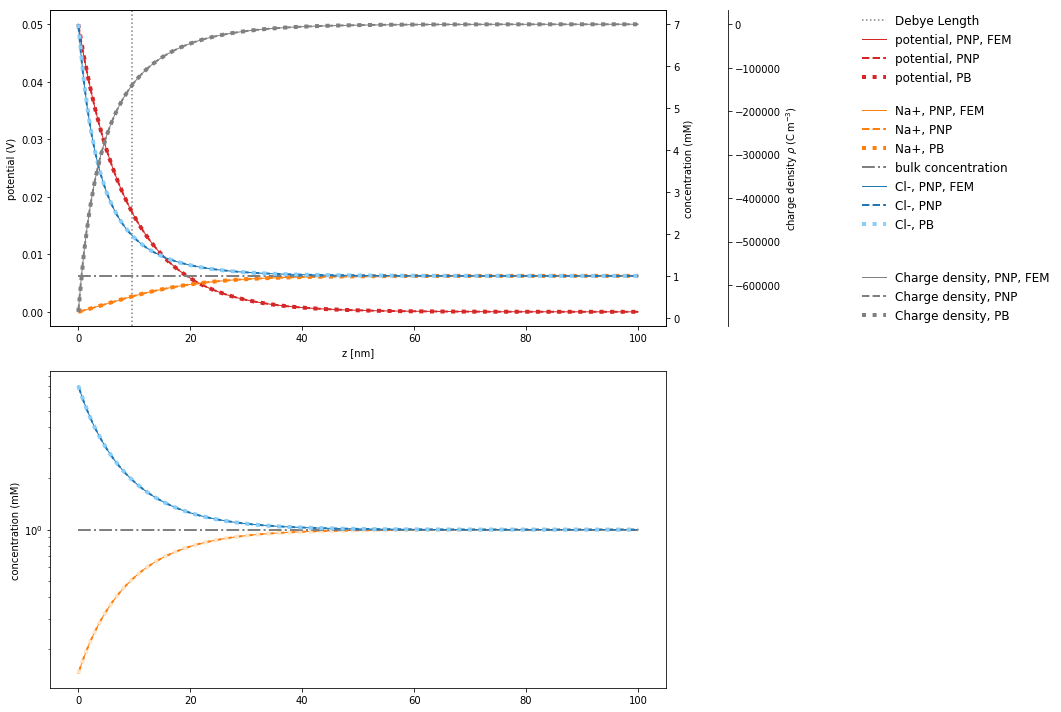

In [11]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_interface'].grid/sc.nano, pnp['fenics_interface'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM', linewidth=1, linestyle='-')
ax1.plot(
    pnp['std_interface'].grid/sc.nano, pnp['std_interface'].potential, 
    marker='', color='tab:red', label='potential, PNP', linewidth=2, linestyle='--')
ax1.plot(
    x/sc.nano, phi, 
    marker='', color='tab:red', label='potential, PB', linewidth=4, linestyle=':')


ax2 = ax1.twinx()
ax2.plot(pnp['fenics_interface'].grid/sc.nano, pnp['fenics_interface'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['std_interface'].grid/sc.nano, pnp['std_interface'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, C[0], 
    marker='', color='tab:orange', label='Na+, PB', linewidth=4, linestyle=':')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_interface'].grid/sc.nano, pnp['fenics_interface'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['std_interface'].grid/sc.nano, pnp['std_interface'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, C[1], 
    marker='', color='lightskyblue', label='Cl-, PB', linewidth=4, linestyle=':')


ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_interface'].grid/sc.nano, pnp['fenics_interface'].charge_density, 
    label='Charge density, PNP, FEM', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['std_interface'].grid/sc.nano, pnp['std_interface'].charge_density, 
    label='Charge density, PNP', color='grey', linewidth=2, linestyle='--')
ax3.plot(x/sc.nano, rho, 
    label='Charge density, PB', color='grey', linewidth=4, linestyle=':')


ax4.semilogy(
    pnp['fenics_interface'].grid/sc.nano, 
    pnp['fenics_interface'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['std_interface'].grid/sc.nano, 
    pnp['std_interface'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, C[0], 
    marker='', color='bisque', label='Na+, PB', linewidth=4, linestyle=':')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_interface'].grid/sc.nano, pnp['fenics_interface'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['std_interface'].grid/sc.nano, pnp['std_interface'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, C[1], 
    marker='', color='lightskyblue', label='Cl-, PB',linewidth=4,linestyle=':')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()

# Convergence issues for CV

In [12]:
# Test case parameters   oö
c=[1.0, 1.0]
z=[ 1, -1]
L=10e-8 # 200 nm
delta_u=0.2 # V
N=200

In [13]:
pnp['std_interface_high_potential'] = PoissonNernstPlanckSystem(
    c, z, L, delta_u=delta_u,N=N,
    solver="hybr", options={'xtol':1e-14})
pnp['std_interface_high_potential'].useStandardInterfaceBC()
uij, nij, lamj = pnp['std_interface_high_potential'].solve()

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


In [14]:
pnp['fenics_interface_high_potential'] = PoissonNernstPlanckSystemFEniCS(c, z, L, delta_u=delta_u,N=200)
pnp['fenics_interface_high_potential'].useStandardInterfaceBC()
uij, nij, _ = pnp['fenics_interface_high_potential'].solve()

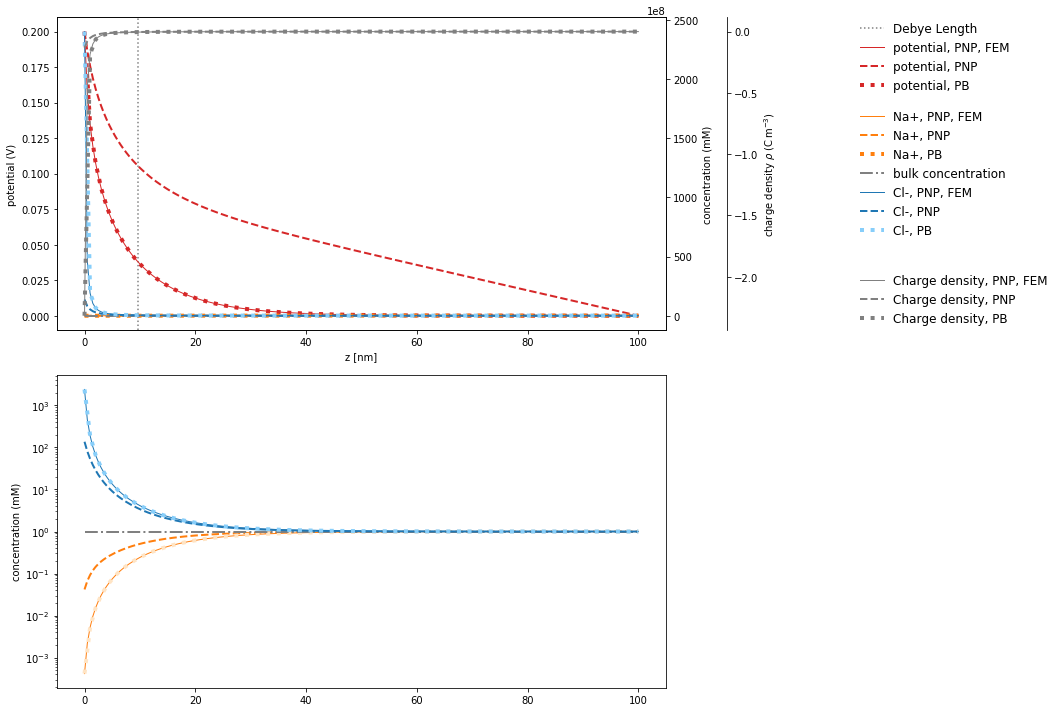

In [15]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_interface_high_potential'].grid/sc.nano, pnp['fenics_interface_high_potential'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM', linewidth=1, linestyle='-')
ax1.plot(
    pnp['std_interface_high_potential'].grid/sc.nano, pnp['std_interface_high_potential'].potential, 
    marker='', color='tab:red', label='potential, PNP', linewidth=2, linestyle='--')
ax1.plot(
    x/sc.nano, phi, 
    marker='', color='tab:red', label='potential, PB', linewidth=4, linestyle=':')


ax2 = ax1.twinx()
ax2.plot(pnp['fenics_interface_high_potential'].grid/sc.nano, pnp['fenics_interface_high_potential'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['std_interface_high_potential'].grid/sc.nano, pnp['std_interface_high_potential'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, C[0], 
    marker='', color='tab:orange', label='Na+, PB', linewidth=4, linestyle=':')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_interface_high_potential'].grid/sc.nano, pnp['fenics_interface_high_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['std_interface_high_potential'].grid/sc.nano, pnp['std_interface_high_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, C[1], 
    marker='', color='lightskyblue', label='Cl-, PB', linewidth=4, linestyle=':')


ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_interface_high_potential'].grid/sc.nano, pnp['fenics_interface_high_potential'].charge_density, 
    label='Charge density, PNP, FEM', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['std_interface_high_potential'].grid/sc.nano, pnp['std_interface_high_potential'].charge_density, 
    label='Charge density, PNP', color='grey', linewidth=2, linestyle='--')
ax3.plot(x/sc.nano, rho, 
    label='Charge density, PB', color='grey', linewidth=4, linestyle=':')


ax4.semilogy(
    pnp['fenics_interface_high_potential'].grid/sc.nano, 
    pnp['fenics_interface_high_potential'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['std_interface_high_potential'].grid/sc.nano, 
    pnp['std_interface_high_potential'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, C[0], 
    marker='', color='bisque', label='Na+, PB', linewidth=4, linestyle=':')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_interface_high_potential'].grid/sc.nano, pnp['fenics_interface_high_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['std_interface_high_potential'].grid/sc.nano, pnp['std_interface_high_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, C[1], 
    marker='', color='lightskyblue', label='Cl-, PB',linewidth=4,linestyle=':')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()

# Standard cell boundary conditions

In [16]:
c=[1000.0, 1000.0]
z=[ 1, -1]
L=20e-9 # 20 nm
delta_u=0.8 # V

In [17]:
pnp['std_cell'] = PoissonNernstPlanckSystem(
    c, z, L, delta_u=delta_u,
    solver="hybr", options={'xtol':1e-15})
pnp['std_cell'].useStandardCellBC()
uij, nij, lamj = pnp['std_cell'].solve()

xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.


In [18]:
pnp['fenics_cell'] = PoissonNernstPlanckSystemFEniCS(
    c, z, L, delta_u=delta_u)
pnp['fenics_cell'].useStandardCellBC()
uij, nij, lamj = pnp['fenics_cell'].solve()

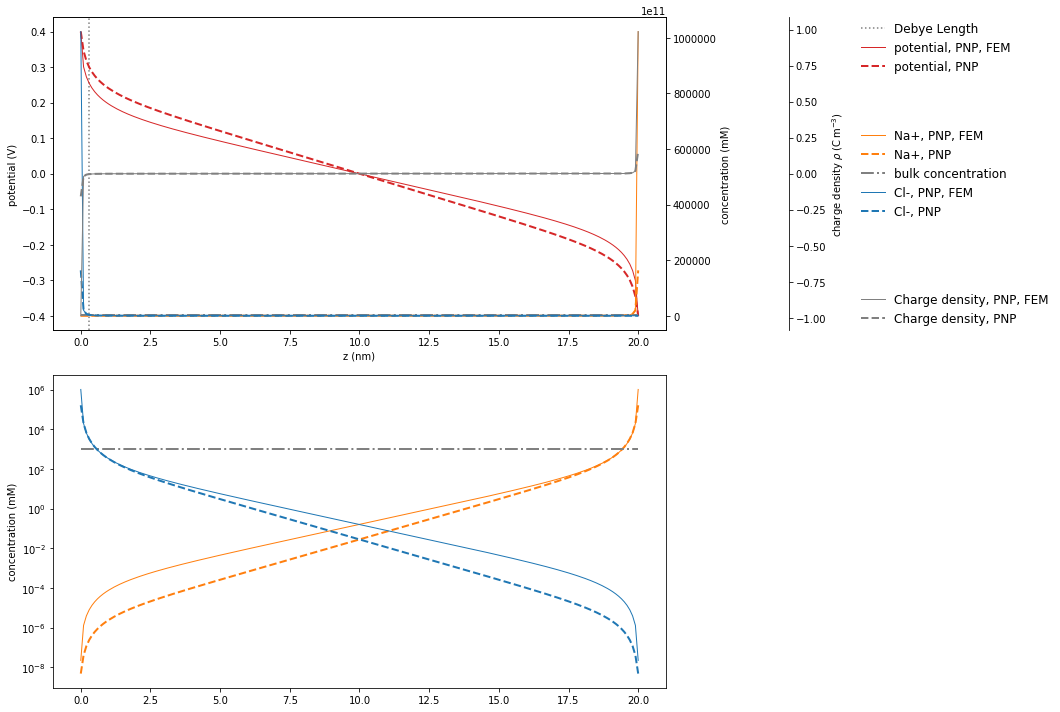

In [19]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM', linewidth=1, linestyle='-')
ax1.plot(
    pnp['std_cell'].grid/sc.nano, pnp['std_cell'].potential, 
    marker='', color='tab:red', label='potential, PNP', linewidth=2, linestyle='--')

ax2 = ax1.twinx()
ax2.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['std_cell'].grid/sc.nano, pnp['std_cell'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['std_cell'].grid/sc.nano, pnp['std_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].charge_density, 
    label='Charge density, PNP, FEM', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['std_cell'].grid/sc.nano, pnp['std_cell'].charge_density, 
    label='Charge density, PNP', color='grey', linewidth=2, linestyle='--')

ax4.semilogy(
    pnp['fenics_cell'].grid/sc.nano, 
    pnp['fenics_cell'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['std_cell'].grid/sc.nano, 
    pnp['std_cell'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['std_cell'].grid/sc.nano, pnp['std_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')

ax1.set_xlabel('z (nm)')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()

# Standard cell boundary conditions with initial values

In [20]:
delta_u=1.2 # V

In [21]:
pnp['fenics_cell_high_potential'] = PoissonNernstPlanckSystemFEniCS(
    c, z, L, delta_u=delta_u, potential0=pnp['fenics_cell'].potential, concentration0=pnp['fenics_cell'].concentration,N=1000)
pnp['fenics_cell_high_potential'].useStandardCellBC()
uij, nij, lamj = pnp['fenics_cell_high_potential'].solve()

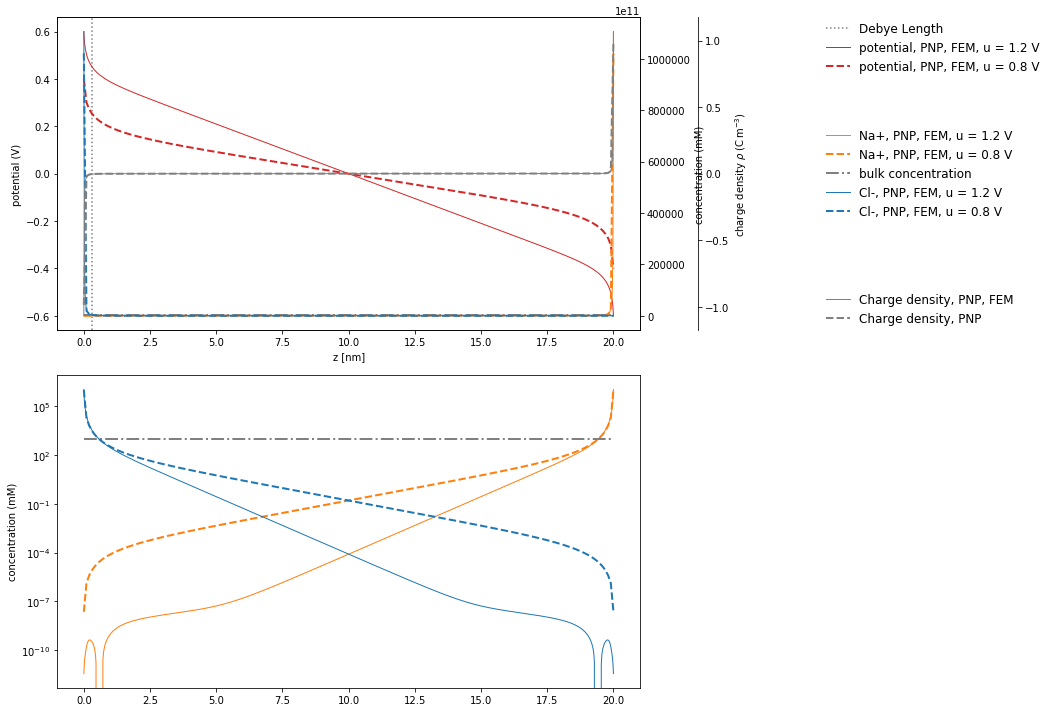

In [22]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_cell_high_potential'].grid/sc.nano, pnp['fenics_cell_high_potential'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM, u = 1.2 V', linewidth=1, linestyle='-')
ax1.plot(
    pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM, u = 0.8 V', linewidth=2, linestyle='--')

ax2 = ax1.twinx()
ax2.plot(pnp['fenics_cell_high_potential'].grid/sc.nano, pnp['fenics_cell_high_potential'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM, u = 1.2 V', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM, u = 0.8 V', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_cell_high_potential'].grid/sc.nano, pnp['fenics_cell_high_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, u = 1.2 V', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, u = 0.8 V', linewidth=2, linestyle='--')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_cell_high_potential'].grid/sc.nano, pnp['fenics_cell_high_potential'].charge_density, 
    label='Charge density, PNP, FEM', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].charge_density, 
    label='Charge density, PNP', color='grey', linewidth=2, linestyle='--')

ax4.semilogy(
    pnp['fenics_cell_high_potential'].grid/sc.nano, 
    pnp['fenics_cell_high_potential'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell'].grid/sc.nano, 
    pnp['fenics_cell'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_cell_high_potential'].grid/sc.nano, pnp['fenics_cell_high_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()

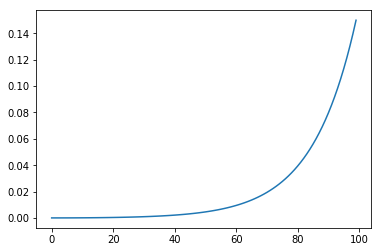

In [23]:
plt.plot(pnp['fenics_cell'].concentration[0][0:100])

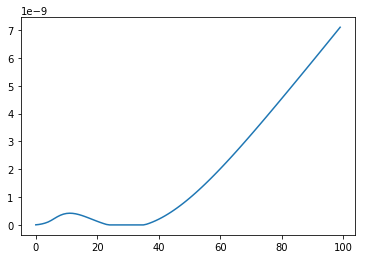

In [24]:
plt.plot(pnp['fenics_cell_high_potential'].concentration[0][0:100])

# Reference concentration cell boundary conditions

In [25]:
import fenics as fn

In [26]:
# Test case parameters
c=[1000.0, 1000.0]
z=[ 1, -1]
L=20e-9 # 20 nm
a=28e-9 # 28 x 28 nm area
delta_u=0.2 # V

In [27]:
pnp['fenics_cell_low_potential'] = PoissonNernstPlanckSystemFEniCS(
    c, z, L, delta_u=delta_u, N = 200)
pnp['fenics_cell_low_potential'].useStandardCellBC()
uij, nij, lamj = pnp['fenics_cell_low_potential'].solve()

In [28]:
pnp['fenics_cell_c_ref'] = PoissonNernstPlanckSystemFEniCS(
    c, z, L, delta_u=delta_u, N = 200,
    potential0=pnp['fenics_cell_low_potential'].potential,
    concentration0=pnp['fenics_cell_low_potential'].concentration)
pnp['fenics_cell_c_ref'].useCentralReferenceConcentrationBasedCellBC()
uij, nij, lamj = pnp['fenics_cell_c_ref'].solve()

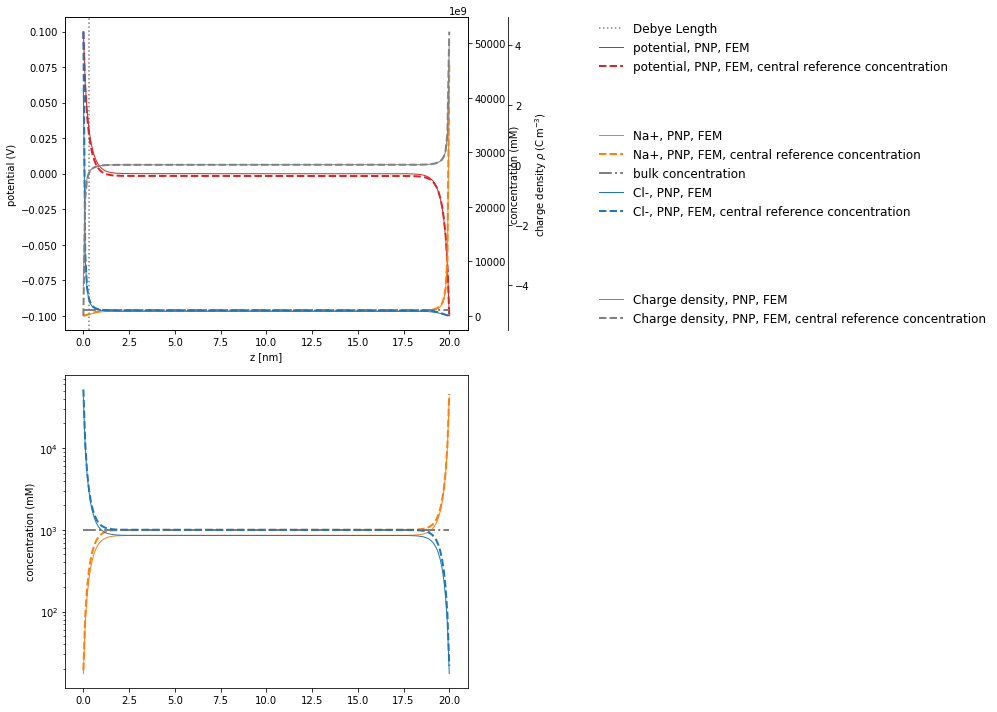

In [29]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_cell_low_potential'].grid/sc.nano, pnp['fenics_cell_low_potential'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM', linewidth=1, linestyle='-')
ax1.plot(
    pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM, central reference concentration', linewidth=2, linestyle='--')

ax2 = ax1.twinx()
ax2.plot(pnp['fenics_cell_low_potential'].grid/sc.nano, pnp['fenics_cell_low_potential'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM, central reference concentration', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_cell_low_potential'].grid/sc.nano, pnp['fenics_cell_low_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, central reference concentration', linewidth=2, linestyle='--')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_cell_low_potential'].grid/sc.nano, pnp['fenics_cell_low_potential'].charge_density, 
    label='Charge density, PNP, FEM', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].charge_density, 
    label='Charge density, PNP, FEM, central reference concentration', color='grey', linewidth=2, linestyle='--')

ax4.semilogy(
    pnp['fenics_cell_low_potential'].grid/sc.nano, 
    pnp['fenics_cell_low_potential'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell_c_ref'].grid/sc.nano, 
    pnp['fenics_cell_c_ref'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM, central reference concentration', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_cell_low_potential'].grid/sc.nano, pnp['fenics_cell_low_potential'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, central reference concentration', linewidth=2, linestyle='--')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()

In [30]:
delta_u=0.4

In [31]:
pnp['fenics_cell_c_ref_u_0.4'] = PoissonNernstPlanckSystemFEniCS(
    c, z, L, delta_u=delta_u, N=1000,
    potential0=pnp['fenics_cell_c_ref'].potential,
    concentration0=pnp['fenics_cell_c_ref'].concentration)
pnp['fenics_cell_c_ref_u_0.4'].useCentralReferenceConcentrationBasedCellBC()
uij, nij, lamj = pnp['fenics_cell_c_ref_u_0.4'].solve()

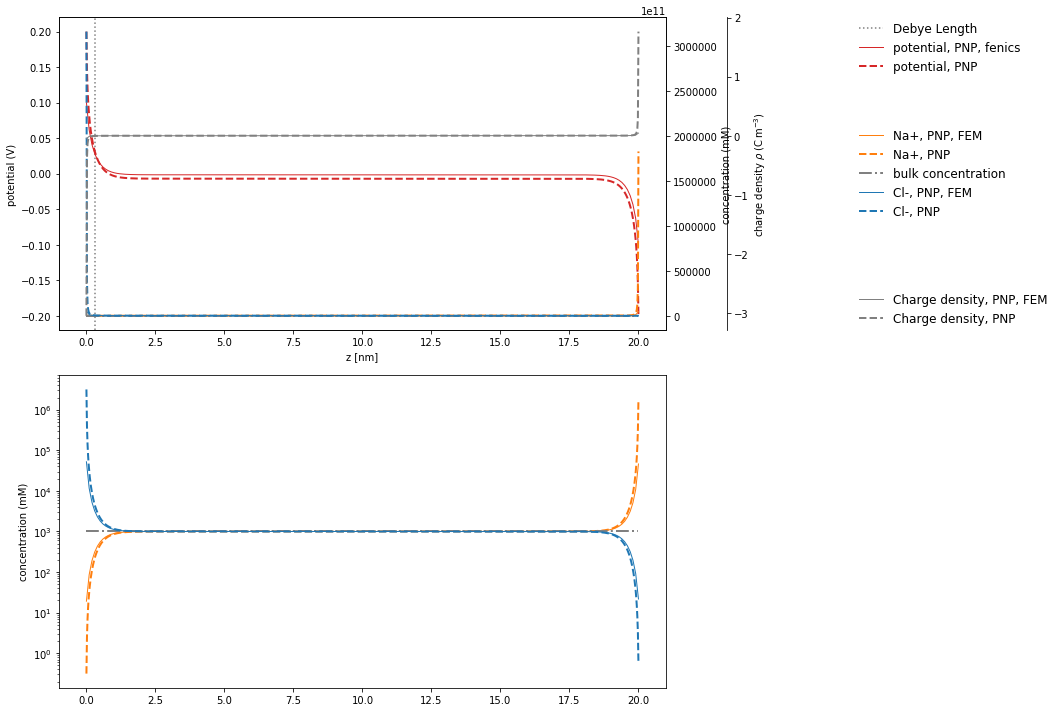

In [32]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].potential, 
    marker='', color='tab:red', label='potential, PNP, fenics', linewidth=1, linestyle='-')
ax1.plot(
    pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].potential, 
    marker='', color='tab:red', label='potential, PNP', linewidth=2, linestyle='--')

ax2 = ax1.twinx()
ax2.plot(pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].charge_density, 
    label='Charge density, PNP, FEM', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].charge_density, 
    label='Charge density, PNP', color='grey', linewidth=2, linestyle='--')

ax4.semilogy(
    pnp['fenics_cell_c_ref'].grid/sc.nano, 
    pnp['fenics_cell_c_ref'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, 
    pnp['fenics_cell_c_ref_u_0.4'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_cell_c_ref'].grid/sc.nano, pnp['fenics_cell_c_ref'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='--')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()

In [33]:
delta_u=0.5

In [34]:
pnp['fenics_cell_c_ref_u_0.6'] = PoissonNernstPlanckSystemFEniCS(
    c, z, L, delta_u=delta_u, N=6000,
    potential0=pnp['fenics_cell_c_ref_u_0.4'].potential,
    concentration0=pnp['fenics_cell_c_ref_u_0.4'].concentration)
pnp['fenics_cell_c_ref_u_0.6'].useCentralReferenceConcentrationBasedCellBC()
uij, nij, lamj = pnp['fenics_cell_c_ref_u_0.6'].solve()

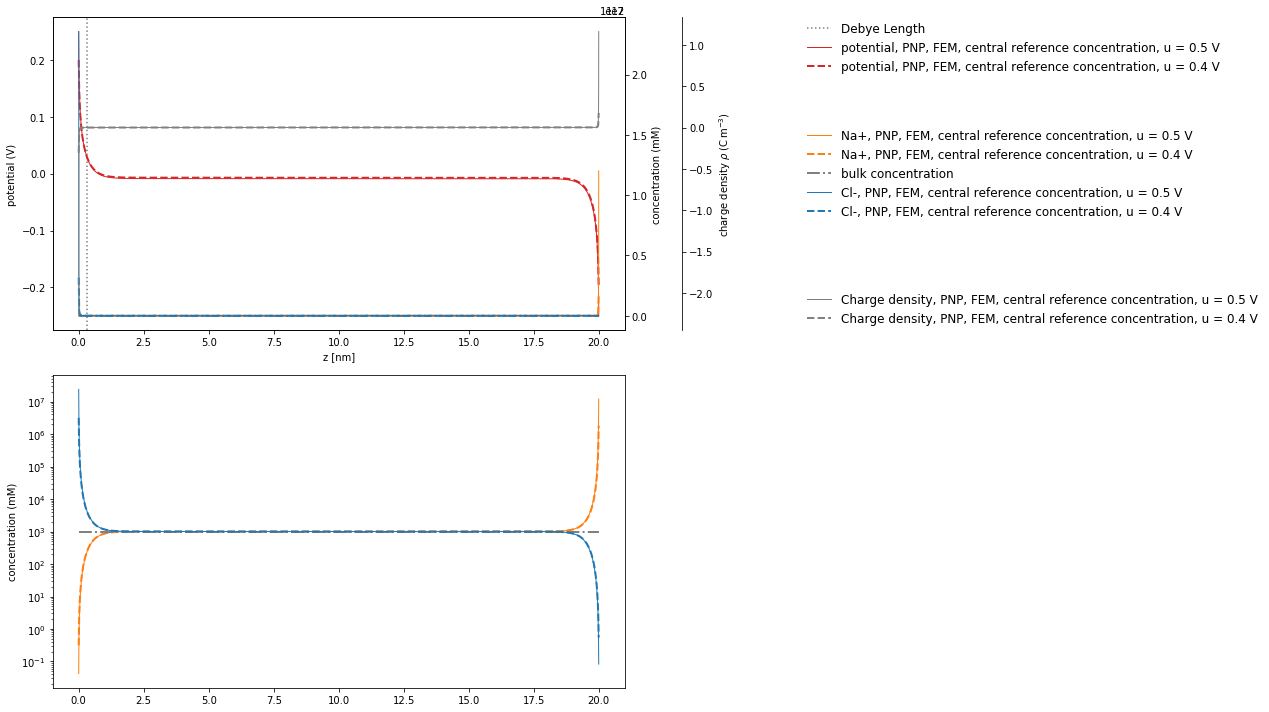

In [35]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[20,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_cell_c_ref_u_0.6'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.6'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM, central reference concentration, u = 0.5 V', linewidth=1, linestyle='-')
ax1.plot(
    pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM, central reference concentration, u = 0.4 V', linewidth=2, linestyle='--')

ax2 = ax1.twinx()
ax2.plot(pnp['fenics_cell_c_ref_u_0.6'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.6'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM, central reference concentration, u = 0.5 V', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM, central reference concentration, u = 0.4 V', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_cell_c_ref_u_0.6'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.6'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, central reference concentration, u = 0.5 V', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, central reference concentration, u = 0.4 V', linewidth=2, linestyle='--')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_cell_c_ref_u_0.6'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.6'].charge_density, 
    label='Charge density, PNP, FEM, central reference concentration, u = 0.5 V', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].charge_density, 
    label='Charge density, PNP, FEM, central reference concentration, u = 0.4 V', color='grey', linewidth=2, linestyle='--')

ax4.semilogy(
    pnp['fenics_cell_c_ref_u_0.6'].grid/sc.nano, 
    pnp['fenics_cell_c_ref_u_0.6'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM, central reference concentration, u = 0.5 V', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, 
    pnp['fenics_cell_c_ref_u_0.4'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM, central reference concentration, u = 0.4 V', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_cell_c_ref_u_0.6'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.6'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, central reference concentration, u = 0.5 V', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_cell_c_ref_u_0.4'].grid/sc.nano, pnp['fenics_cell_c_ref_u_0.4'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, central reference concentration, u = 0.4 V', linewidth=2, linestyle='--')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()

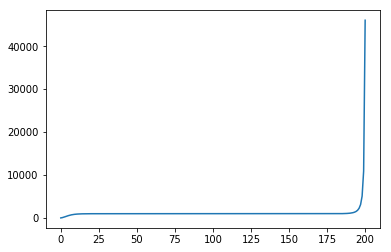

In [36]:
plt.plot(pnp['fenics_cell_c_ref'].concentration[0])

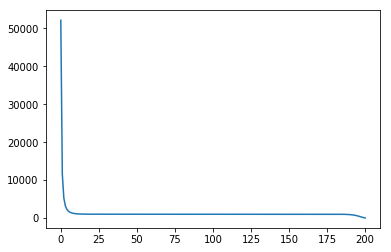

In [37]:
plt.plot(pnp['fenics_cell_c_ref'].concentration[1])

# Stern layer cell boundary conditions

In [38]:
# Test case parameters   oö
c=[1000.0, 1000.0]
z=[ 1, -1]
L=20e-9 # 20 nm
a=28e-9 # 28 x 28 nm area
lambda_S=5e-11
# lambda_S=1
delta_u=0.8 # V

In [39]:
pnp['fenics_stern_layer_cell'] = PoissonNernstPlanckSystemFEniCS(
    c, z, L, delta_u=delta_u, N = 200, lambda_S=lambda_S)
pnp['fenics_stern_layer_cell'].useSternLayerCellBC()
uij, nij, lamj = pnp['fenics_stern_layer_cell'].solve()

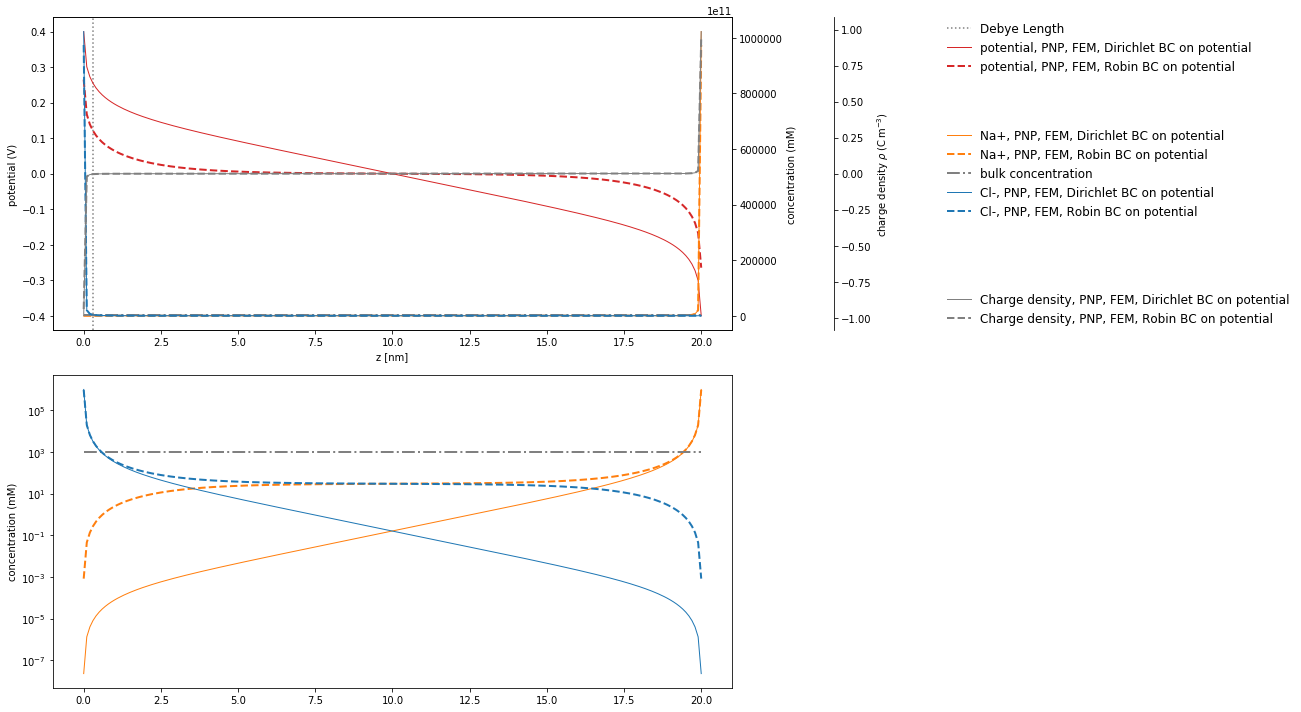

In [40]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)
phi = potential(x, c, z, delta_u) 
C =   concentration(x, c, z, delta_u)
rho = charge_density(x, c, z, delta_u) 
deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[20,10])

ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')

ax1.plot(
    pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM, Dirichlet BC on potential', linewidth=1, linestyle='-')
ax1.plot(
    pnp['fenics_stern_layer_cell'].grid/sc.nano, pnp['fenics_stern_layer_cell'].potential, 
    marker='', color='tab:red', label='potential, PNP, FEM, Robin BC on potential', linewidth=2, linestyle='--')

ax2 = ax1.twinx()
ax2.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM, Dirichlet BC on potential', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_stern_layer_cell'].grid/sc.nano, pnp['fenics_stern_layer_cell'].concentration[0], 
    marker='', color='tab:orange', label='Na+, PNP, FEM, Robin BC on potential', linewidth=2, linestyle='--')
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax2.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, Dirichlet BC on potential', linewidth=1, linestyle='-')
ax2.plot(pnp['fenics_stern_layer_cell'].grid/sc.nano, pnp['fenics_stern_layer_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, Robin BC on potential', linewidth=2, linestyle='--')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.15))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)

ax3.plot(pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].charge_density, 
    label='Charge density, PNP, FEM, Dirichlet BC on potential', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp['fenics_stern_layer_cell'].grid/sc.nano, pnp['fenics_stern_layer_cell'].charge_density, 
    label='Charge density, PNP, FEM, Robin BC on potential', color='grey', linewidth=2, linestyle='--')

ax4.semilogy(
    pnp['fenics_cell'].grid/sc.nano, 
    pnp['fenics_cell'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM, Dirichlet BC on potential', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_stern_layer_cell'].grid/sc.nano, 
    pnp['fenics_stern_layer_cell'].concentration[0], marker='', color='tab:orange', 
    label='Na+, PNP, FEM, Robin BC on potential', linewidth=2, linestyle='--')
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], 
    label='bulk concentration', color='grey', linewidth=2, linestyle='-.')


ax4.semilogy(
    pnp['fenics_cell'].grid/sc.nano, pnp['fenics_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, Dirichlet BC on potential', linewidth=1, linestyle='-')
ax4.semilogy(
    pnp['fenics_stern_layer_cell'].grid/sc.nano, pnp['fenics_stern_layer_cell'].concentration[1], 
    marker='', color='tab:blue', label='Cl-, PNP, FEM, Robin BC on potential', linewidth=2, linestyle='--')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper left',  bbox_to_anchor=(1.3,1.02), fontsize=12, frameon=False)
ax2.legend(loc='center left', bbox_to_anchor=(1.3,0.5),  fontsize=12, frameon=False)
ax3.legend(loc='lower left',  bbox_to_anchor=(1.3,-0.02), fontsize=12, frameon=False)

fig.tight_layout()
plt.show()